In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from gensim.models.word2vec import Word2Vec 
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedShuffleSplit
import sklearn
import nltk
import re 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn import metrics
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import precision_score, recall_score,f1_score

from os import getcwd, chdir
import pandas as pd
import pickle as pk

encoding="utf-8"

fpath = getcwd()
print (fpath)
# Change your path here
chdir(fpath) 

/content


# Data preparation

In [5]:
train_path = "/content/drive/MyDrive/colab/nus/5004 PLP/nmsm/datasets/Data/trainset.pk"
test_path = "/content/drive/MyDrive/colab/nus/5004 PLP/nmsm/datasets/Data/testset.pk"

trainset = pk.load(open(train_path, "rb"))
testset = pk.load(open(test_path, "rb"))

In [9]:
trainset[0]

["i've been here many many times and have never had a bad time. everything has always been up to par. i literally have no complaints.\r\n\r\n\r\n\r\nand - i recently dropped a personal check made out to me while getting cash out to pay my bill. the manager found it and mailed it back to my client. talk about honest service. \r\n\r\n\r\n\r\nbj's is our go to place for an easy weekend lunch. their home brewed root beer is super good.",
 1]

In [10]:
GLOVE_6B_100D_PATH = "/content/drive/MyDrive/colab/nus/5004 PLP/nmsm/datasets/Data/glove.6B.100d.txt"

In [14]:
X_train = [t[0].split() for t in trainset]
X_test = [t[0].split() for t in testset]

X = X_train + X_test

Y_train = [t[1] for t in trainset]
Y_test = [t[1] for t in testset]

y = Y_train + Y_test

In [ ]:
X[:1]

In [13]:
len(X)

21730

In [19]:
X, y = np.array(X), np.array(y)

<ipython-input-19-9c102b406c81>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X, y = np.array(X), np.array(y)


# Mean embedding vectorizer

In [20]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(glove_small))])
            #self.dim=len(word2vec["and"])
        else:
            self.dim=0
            
    def fit(self, X, y):
        return self 

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

# Prepare word embeddings from GLOVE

In [21]:
import numpy as np
with open(GLOVE_6B_100D_PATH, "rb") as lines:
    wvec = {line.split()[0].decode(encoding): np.array(line.split()[1:],dtype=np.float32)
               for line in lines}

In [22]:
import struct 

glove_small = {}
all_words = set(w for words in X for w in words)

print(len(all_words))

with open(GLOVE_6B_100D_PATH, "rb") as infile:
    for line in infile:
        parts = line.split()
        word = parts[0].decode(encoding)
        if (word in all_words):
            nums=np.array(parts[1:], dtype=np.float32)
            glove_small[word] = nums

95586


In [23]:
#Prepare word embeddings by training from dataset
model = Word2Vec(X, size=100, window=5, min_count=2, workers=2)
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}

<ipython-input-23-2e808a98110f>:3: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}


In [24]:
# SVM + tfidf based bag-of-words features
#svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("svc", SVC(kernel="linear",C=10.0))])

svc_tfidf = Pipeline([("tfidf_vectorizer", TfidfVectorizer(analyzer=lambda x: x)), ("LR",LogisticRegression(random_state=0, solver='lbfgs'))])

# SVM + vec_from_dataset + MeanEmbedding
svc_w2v = Pipeline([("word2vec vectorizer", MeanEmbeddingVectorizer(w2v)), ("LR",LogisticRegression(random_state=0, solver='lbfgs'))])

# SVM + GLOVE vectors + MeanEmbedding
svc_glove_small = Pipeline([("glove vectorizer", MeanEmbeddingVectorizer(glove_small)), ("LR",LogisticRegression(random_state=0, solver='lbfgs'))])

# Modeling

In [25]:
#Predict using tfidf feature
svc_model = svc_tfidf.fit(X_train,Y_train)
svc_pred = svc_model.predict(X_test)
conf_mat = confusion_matrix(Y_test, svc_pred)
print ("SVC:\n",conf_mat)
print(metrics.classification_report(Y_test, svc_pred))

SVC:
 [[1571  226]
 [ 373 1627]]
              precision    recall  f1-score   support

          -1       0.81      0.87      0.84      1797
           1       0.88      0.81      0.84      2000

    accuracy                           0.84      3797
   macro avg       0.84      0.84      0.84      3797
weighted avg       0.84      0.84      0.84      3797



In [26]:
#Predict using pre-trained glove model
svc_glove_model = svc_glove_small.fit(X_train,Y_train)
svc_glove_pred = svc_glove_model.predict(X_test)
conf_mat = confusion_matrix(Y_test, svc_glove_pred)
print ("SVC_glove:\n",conf_mat)
print(metrics.classification_report(Y_test, svc_glove_pred))

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SVC_glove:
 [[1476  321]
 [ 630 1370]]
              precision    recall  f1-score   support

          -1       0.70      0.82      0.76      1797
           1       0.81      0.69      0.74      2000

    accuracy                           0.75      3797
   macro avg       0.76      0.75      0.75      3797
weighted avg       0.76      0.75      0.75      3797



In [27]:
#Predict using self-trained word2vec
svc_w2v_model = svc_w2v.fit(X_train,Y_train)
svc_w2v_pred = svc_w2v_model.predict(X_test)
conf_mat = confusion_matrix(Y_test, svc_w2v_pred)
print ("SVC_w2v:\n",conf_mat)
print(metrics.classification_report(Y_test, svc_w2v_pred))

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


SVC_w2v:
 [[1440  357]
 [ 555 1445]]
              precision    recall  f1-score   support

          -1       0.72      0.80      0.76      1797
           1       0.80      0.72      0.76      2000

    accuracy                           0.76      3797
   macro avg       0.76      0.76      0.76      3797
weighted avg       0.76      0.76      0.76      3797



In [28]:
# benchmark all the models
all_models = [
    ("svc_tfidf", svc_tfidf),
    ("svc_w2v", svc_w2v),
    ("svc_glove_small",svc_glove_small)
]

In [29]:
##how the ranking depends on the amount of training data
def benchmark(model, X, y, n,X_test,y_test):
    scores = []
    sss = StratifiedShuffleSplit(n_splits=5, train_size=n,test_size =len(y)-n )
    
    for train, test in sss.split(X, y):
        X_train = X[train]
        y_train = y[train]
        scores.append(accuracy_score(model.fit(X_train, y_train).predict(X_test), y_test))
        break
    return np.mean(scores)

In [30]:
train_sizes = [1000,5000,10000,15000,17900]
table = []
for name, model in all_models:
    for n in train_sizes:
        table.append({'model': name, 
                      'accuracy': benchmark(model, np.array(X_train), np.array(Y_train), n,X_test, Y_test), 
                      'train_size': n})
df = pd.DataFrame(table)

<ipython-input-30-7a9bb352f3a3>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  'accuracy': benchmark(model, np.array(X_train), np.array(Y_train), n,X_test, Y_test),
<ipython-input-30-7a9bb352f3a3>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  'accuracy': benchmark(model, np.array(X_train), np.array(Y_train), n,X_test, Y_test),
<ipython-input-30-7a9bb352f3a3>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If yo

[Text(0, 0.5, 'accuracy')]

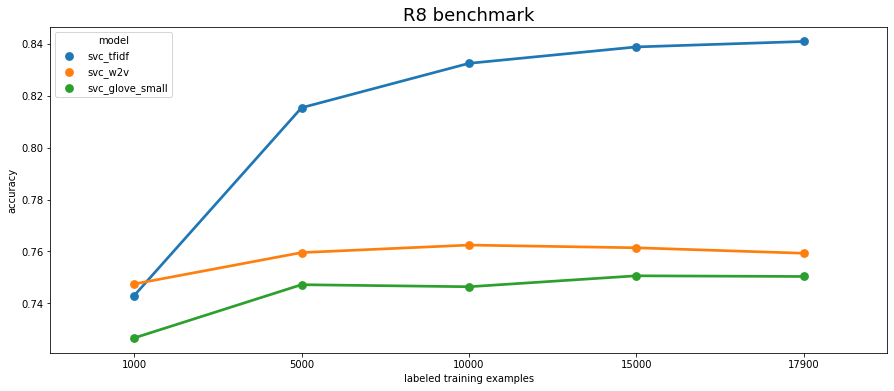

In [31]:
plt.figure(figsize=(15, 6))
fig = sns.pointplot(x='train_size', y='accuracy', hue='model', 
                    data=df[df.model.map(lambda x: x in ["svc_tfidf", "svc_w2v", "svc_glove_small", ])])
sns.set_context("notebook", font_scale=1.5)
fig.set(ylabel="accuracy")
fig.set(xlabel="labeled training examples")
fig.set(title="R8 benchmark")
fig.set(ylabel="accuracy")